In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import math
import umap

import matplotlib.pyplot as plt
import matplotlib
 
from datetime import datetime 
import pickle as pk

# Load data

In [2]:
file_name = 'dentate-gyrus-neurogenesis_hochgerner'

with open('data/'+file_name+'.pkl', 'rb') as f:
    [x, grouping, milestone_net] = pk.load(f)
    
# For non-UMI
# scale_factor = np.sum(x,axis=1, keepdims=True)/1e4
# x = x/scale_factor    

# Preprocess data

min normailized value: 0.0
max normailized value: 8.6256895


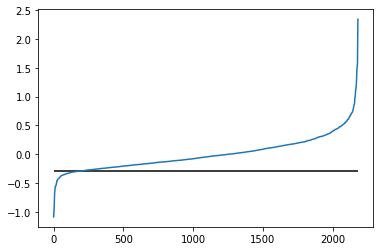

Number of cells in each class: 
1 <---> Granule-mature      1532
0 <---> Granule-immature    1127
3 <---> Neuroblast 2         747
2 <---> Neuroblast 1          94
4 <---> nIPC                  85
dtype: int64


In [3]:
from scTGMVAE import scTGMVAE
tf.keras.backend.clear_session()
model = scTGMVAE()
model.get_data(x, grouping)
model.preprocess_data(gene_num=2000)

# Build model

In [4]:
model.build_model(data_type = 'UMI', dim_latent = 8, dimensions=[16], save_weights=True)

Below is the process to train the momdel. You can skip these steps to section **Inference**.

# Pretrain

In [ ]:
model.pre_train(L=1, batch_size=32, early_stopping_tolerance=1)

# Cluster and initialize model

In [ ]:
from umap.umap_ import nearest_neighbors
from sklearn.utils import check_random_state
z = model.get_latent_z()
n_neighbors = 15
random_state = check_random_state(None)
knn_indices, knn_dists, forest = nearest_neighbors(
    z, n_neighbors, random_state=random_state,
    metric='euclidean', metric_kwds={},
    angular=False, verbose=False,
)

# Build graph
from umap.umap_ import fuzzy_simplicial_set
from scipy.sparse import coo_matrix
n_obs = z.shape[0]
X = coo_matrix(([], ([], [])), shape=(n_obs, 1))
connectivities = fuzzy_simplicial_set(
    X,
    n_neighbors,
    None,
    None,
    knn_indices=knn_indices,
    knn_dists=knn_dists,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
)[0].tocsr()


import igraph as ig
def get_igraph_from_adjacency(adjacency, directed=None):
    """Get igraph graph from adjacency matrix."""
    sources, targets = adjacency.nonzero()
    weights = adjacency[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=directed)
    g.add_vertices(adjacency.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))

    g.es['weight'] = weights

    return g
g = get_igraph_from_adjacency(connectivities)

In [ ]:
# Louvain
!pip install louvain
import louvain
partition_kwargs = {}
partition_type = louvain.RBConfigurationVertexPartition
partition_kwargs["resolution_parameter"] = 0.8
partition_kwargs["seed"] = 0
part = louvain.find_partition(
                g, partition_type,
                **partition_kwargs,
            )
labels_ = np.array(part.membership)
print(np.unique(labels_))

In [ ]:
NUM_CLUSTER = len(np.unique(labels_))
cluster_center = [int((NUM_CLUSTER+(1-i)/2)*i) for i in range(NUM_CLUSTER)]
n_states = int((NUM_CLUSTER+1)*NUM_CLUSTER/2)
mu = np.zeros((8,NUM_CLUSTER))
pi = np.ones((1,n_states)) * 0
for i in np.arange(NUM_CLUSTER):
    mu[:,i] = np.mean(z[labels_==i], axis=0)
    # pi[0, cluster_center[i]] = np.mean(labels_==i)
model.init_GMM(NUM_CLUSTER, mu, pi=pi)  

# Train

In [ ]:
model.train(batch_size=32, L=1, weight=[1,1,1],
            learning_rate=1e-4, early_stopping_tolerance=0.01, plot_every_num_epoch=15)

# Inference

In [5]:
# load model weight
model.load_model('weight/dentate/train.checkpoint', n_clusters=5)
# initialze inference
model.init_inference(L=100) # L is the number of MC samples
# after initialization, we can access some variables by model.pc_x, model.w, model.w_tilde, etc..

In [6]:
import networkx as nx
# compute inference score, and get umap embedding
G = model.comp_inference_score(method='mean',  # posterior mean of c
                               thres=0.5,      # threshold for compute the conditional probablity
                               no_loop=True)   # if no_loop=True, then find the maximum spanning tree
# returned G is the score graph
print(np.round(nx.to_numpy_matrix(G), 2))
print(G.edges)

[[0.   0.34 0.   0.   0.  ]
 [0.34 0.   0.35 0.   0.  ]
 [0.   0.35 0.   0.   0.44]
 [0.   0.   0.   0.   0.36]
 [0.   0.   0.44 0.36 0.  ]]
[(0, 1), (1, 2), (2, 4), (3, 4)]


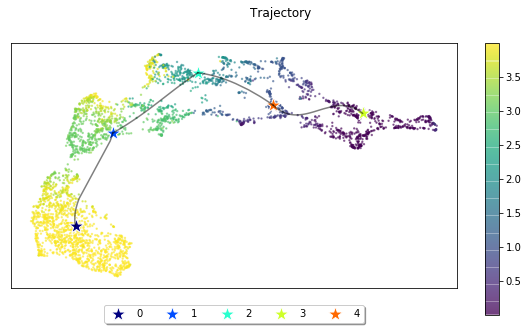

In [7]:
model.plot_trajectory(init_node=3,  # initial node for computing pseudotime
                      cutoff=None)  # cutoff score for edges, if cutoff=None then find the maximum spanning tree

In [8]:
G = model.comp_inference_score(method='map',  
                               thres=0.5,     
                               no_loop=True)  
# returned G is the score graph
print(np.round(nx.to_numpy_matrix(G), 2))
print(G.edges)

[[0.   0.28 0.   0.   0.  ]
 [0.28 0.   0.3  0.   0.  ]
 [0.   0.3  0.   0.   0.36]
 [0.   0.   0.   0.   0.3 ]
 [0.   0.   0.36 0.3  0.  ]]
[(0, 1), (1, 2), (2, 4), (3, 4)]


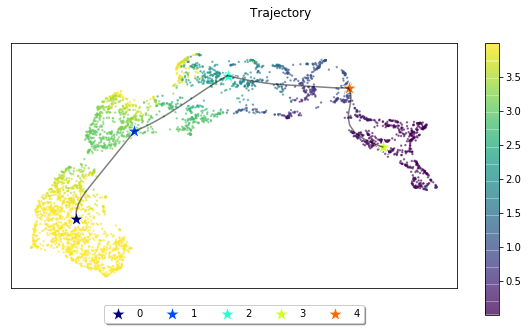

In [9]:
model.plot_trajectory(init_node=3, 
                      cutoff=None) 